#### Measurement Framework Library
# MFLib: ELK Data Export Service

## Prerequisites
The slice has to have already been instrumentized. See the [Instrumentize a Slice](./instrumentize_a_slice.ipynb) notebook.

## General Imports

In [ ]:
import os
import json
import traceback

## Import MFLib
If you have trouble importing mflib it may be because:
* After you do the MFLib install, you will have to restart the notebook kernel before the importing of MFLib will work.
* When your Jupyter Hub server container is reloaded, the above install will may be removed. If you log out or have to restart the server you will get an import error when trying to import MFLib.
See [Install MFLib](./mflib_install.ipynb)

In [ ]:
import mflib 
print(f"MFLib version  {mflib.__version__} " )

from mflib.mflib import MFLib

## Set Experiment Slice Name

#### If you are using the slice created in the Instrumentize a Slice notebook, you will have this instrumentized topology and slice name.

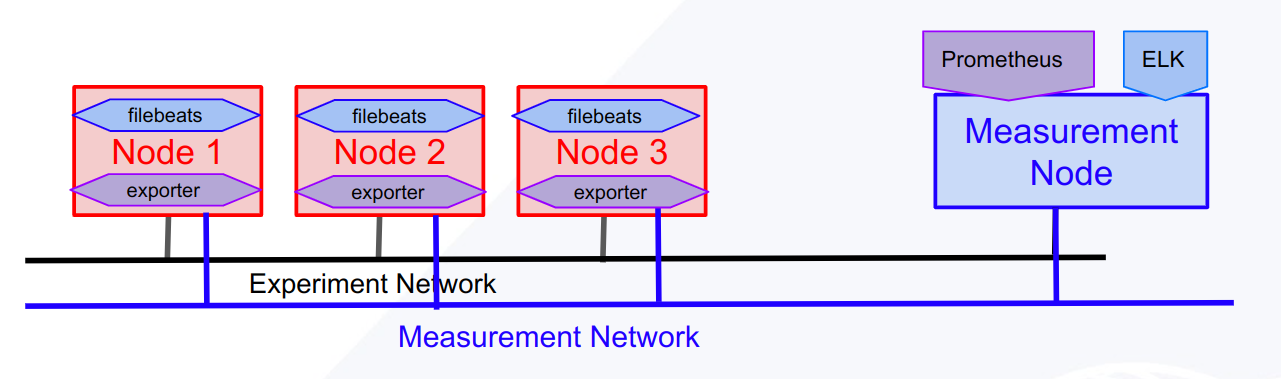

In [ ]:
# The slice name of the slice with which you want to interact.
slice_name = "MyMonitoredSlice"

## Create the MFLib Object
Create the new MFLib object by passing in the name of the slice with which you will be interacting.
This will take a few seconds. 
Note: If the slice has not been previously initialized and instrumentized then this step will attempt to initialize the slice. That will take ~ 5 minutes. However, as of this writing, if the slice is not instrumentized, instrumentize will not be performed.

In [ ]:
mf = MFLib(slice_name)

# Using the ElasticDump tool for exporting and importing data

Elasticsearch uses a data structure called an inverted index that supports very fast full-text searches. An inverted index lists every unique word that appears in any document and identifies all of the documents each word occurs in.

An index can be thought of as an optimized collection of documents and each document is a collection of fields, which are the key-value pairs that contain your data.

For more Elasticsearch index information, visit https://www.elastic.co/blog/what-is-an-elasticsearch-index

## Installing Dependencies
#### ** Notice **
#### These steps need to be converted into an ansible playbook. Currently, they will only work on operating systems with apt.
#### Please manually install with the steps below IF you are using an operating system with a different package manager.

1. Install NPM
2. Install ElasticDump
3. Create indices directory in elk files

#### Run the cell below if you have apt

In [ ]:
commands = ["sudo apt-get install npm -y", "sudo npm install elasticdump -g", "sudo mkdir /home/mfuser/services/elk/files/indices"]

for command in commands:
    try:
        stdout, stderr = mf.meas_node.execute(command)
        print(f"stdout: {stdout}")
    except Exception as e:
        print(f"Exception: {e}")

## Exporting

We can export these indices from our Fabric slice so that they can be used in an ELK cluster somewhere else. When you export an index from Elasticsearch, the index file will be placed onto the Measurement Node (where Elasticsearch is running).

### View index information and choose indices to export

#### View full index information on Kibana (optional)
Before you can view the Kibana dashboard you need to tunnel through the bastion host into the measurement node. See [Accessing ELK Logs & Metrics](./elk_kibana.ipynb)

In [ ]:
print(f"Once you have created a tunnel, you can view your index information at  http://localhost:{mf.kibana_tunnel_local_port}/app/management/data/index_management/indices")

# Get ELK username & password
data = {}
data["get"] = ["nginx_id", "nginx_password"]
print("With the following credentials:")
info_results = mf.info("elk", data)

#### Get index names from Kibana by using the mflib.info call to the elk service.

The elk service will utilize the following API call:

curl -XGET http://localhost:9200/_cat/indices/?h=index

Full API information found here:

https://www.elastic.co/guide/en/elasticsearch/reference/current/cat-indices.html

In [ ]:
# Create a dictionary to pass to the service.
data = {}

# Set the info you want to get.
data["get"] = ["index_names"]
info_results = mf.info("elk", data)

# Set the indices tuple to use later
if info_results["success"] and "index_names" in info_results:
    indices = tuple(info_results["index_names"])

#### Uncomment and modify below line to choose specific indices instead

In [ ]:
# indices = tuple(["kibana_sample_data_ecommerce", "kibana_sample_data_logs", "kibana_sample_data_flights"])

#### Confirm desired indices are selected for export

In [ ]:
print("Prepared to export the following indices:\n")
for index in indices:
    print(index)

### Export indices
This will start the elastic dump service and export all chosen indices. See https://github.com/elasticsearch-dump/elasticsearch-dump

Depending on how much data you are exporting, this could take awhile. You can use "Check export progress" below if you temporarily lose this page.

In [ ]:
data = {}
data["commands"] = []
data["commands"].append( {"cmd":"export_index", "indices":indices} )
# Call update to run elasticdump tool service
results = mf.update("elk", data)

#### Check export progress

This is useful if you leave the page or lose your progress on the export process running above. Please note: A failed export may stay in the "Export in Progress" section indefinitely until manually removed.

In [ ]:
# Create a dictionary to pass to the service.
data = {}

# Set the info you want to get.
data["get"] = ["index_downloads"]
info_results = mf.info("elk", data)

### Download index to local storage

Once the file is ready to be downloaded you can edit the code below to use the mf library.

In [ ]:
# EDIT THIS - choose from "Files finished exporting above"
files = ["example_index_name.json"]

# Specify output location (Default is current directory)
outputDirectory = "./"
stdout = []
for file in files:
    stdout.append(mf.download_service_file("elk", "files/indices/" + file , outputDirectory + file))

## Importing

Once you have saved index data, you can import it into any ELK cluster you have access to.

### Import index data into ELK cluster on your fabric slice

#### You can choose between uploading a directory or a list of files
##### Upload a list of files:

In [ ]:
# EDIT THIS - choose a list of index files from your local storage to import
local_files = ["/home/fabric/work/jupyter-examples/fabric_examples/mflib/example_index_name.json"]

output = mf.upload_service_files("elk", local_files)

##### Upload a directory:

In [ ]:
# EDIT THIS - choose a directory from your local storage to import
local_dir = "/home/fabric/work/jupyter-examples/fabric_examples/mflib/export_test"

output = mf.upload_service_directory("elk",local_dir)

In [ ]:
# Now that they are on the meas node, we can call them by name
# Remove the local path and keep just the index names
filenames = []
for file in local_files:
    filenames.append(os.path.basename(file))

In [ ]:
# Then we will import the files into the ELK cluster
data = {}
data["commands"] = []
data["commands"].append( {"cmd":"import_index", "indices":filenames} )
results = mf.update("elk", data)

### Import index data onto a VM on your local machine preconfigured with a Vagrant box

#### Install Vagrant VM instructions

In [ ]:
# How to install / startup VM and then import data into ELK cluster

In [ ]:
# In progress.